In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
device = "cuda:0"

In [ ]:
# Load LLaVa
from custom_llava import CustomLlava

custom_llava = CustomLlava()

In [8]:
# Load Owl
from custom_owl import CustomOwl

custom_owl = CustomOwl()

In [9]:
# Load projection module
from projection_modules import CopyProjectionModule, TransformerProjectionModule, DeeperMLPProjectionModule

new_token_projection = DeeperMLPProjectionModule()  # CopyProjectionModule()


In [10]:
new_token_projection.to(device)
custom_llava.to(device)
custom_llava.llava_model.multi_modal_projector.to(device)
_ = custom_owl.to(device)

## Load coco

In [ ]:
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import os


# Initialize COCO instances for annotations and images
dataDir = '../datasets/COCO'
dataType = 'train2017'  # or 'val2017', depending on the dataset split
annFile = os.path.join(dataDir, 'annotations', f'instances_{dataType}.json')
imgDir = os.path.join(dataDir, dataType)

# Initialize COCO instance
coco = COCO(annFile)

# Get all category IDs and their corresponding names
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_names = [cat['name'] for cat in cats]

# Load all image IDs
img_ids = coco.getImgIds()

# Dictionary to store image annotations and PIL images
image_dict = {}

# Loop through each image
for img_id in img_ids:
    # Load image data
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(imgDir, img_info['file_name'])
    
    # Load image as PIL
    img_pil = Image.open(img_path)
    
    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    
    # Get list of classes present in the image
    class_ids = [ann['category_id'] for ann in anns]
    classes = set([cat_names[cat_ids.index(cid)] for cid in class_ids])
    
    # Add image and class list to dictionary
    image_dict[img_id] = {
        'image': img_pil,
        'classes': classes
    }

### Test

In [9]:
sample_ids = list(image_dict.keys())

sample = image_dict[sample_ids[0]]
image = sample["image"]
class_set = sample["classes"]

In [ ]:
hall_class = "person"
prompt = f"<image>\nUSER: Is there a {hall_class} in the image? Only answer with 'yes' or 'no'.\nASSISTANT:"

owl_vision_embedding = custom_owl.get_vision_features(image)
out_test = custom_owl.run_from_vision_features([hall_class], owl_vision_embedding)

image_features_fromowl = new_token_projection(owl_vision_embedding[:, 1:])
custom_llava.generate(prompt, image, custom_vision=image_features_fromowl)

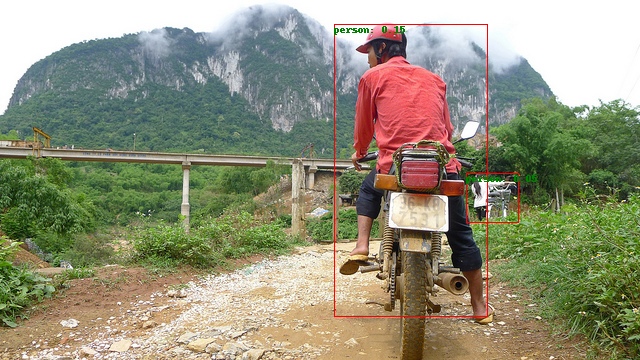

In [11]:
det_image = custom_owl.draw_detections(image, [hall_class], out_test, 0.05)
display(det_image)

## Test negative-hallucinations it for all images

In [ ]:
import torch
from tqdm import tqdm

MAX_SAMPLES = 1000
sample_ids = list(image_dict.keys())

yes_conf = []
no_conf = []

for i in tqdm(range(MAX_SAMPLES)):
    # Get sample image and class set
    sample = image_dict[sample_ids[i]]
    image = sample["image"].convert("RGB")
    class_set = sample["classes"]

    # For each object class
    for hall_class in class_set:
        prompt = f"<image>\nUSER: Is there a {hall_class} in the image? Only answer with 'yes' or 'no'.\nASSISTANT:"

        # Get owl vision embedding and owl output
        owl_vision_embedding = custom_owl.get_vision_features(image).detach()
        out_test = custom_owl.run_from_vision_features([hall_class], owl_vision_embedding)
        for key in out_test.keys():
            out_test[key] = out_test[key].detach()

        # Align embedding and run LLaVa
        image_features_fromowl = new_token_projection(owl_vision_embedding[:, 1:]).detach()  # TODO do i need [:, 1:]??
        gen_text = custom_llava.generate(prompt, image, custom_vision=image_features_fromowl)

        # Compute max owl confidence for class
        max_conf = torch.max(custom_owl.post_process_detection(out_test, threshold=0, target_sizes=[image.size])["scores"]).detach()

        # Get yes/no answer
        ans = gen_text.split("ASSISTANT: ")[1]

        if ans == "Yes":
            yes_conf.append(max_conf)
        elif ans == "No":
            no_conf.append(max_conf)
        else:
            print("Answer not binary, skipping")


In [ ]:
torch.mean(torch.tensor(yes_conf)), torch.mean(torch.tensor(no_conf))

In [32]:
yes_conf_np = [float(conf.cpu().numpy()) for conf in yes_conf]
no_conf_np = [float(conf.cpu().numpy()) for conf in no_conf]

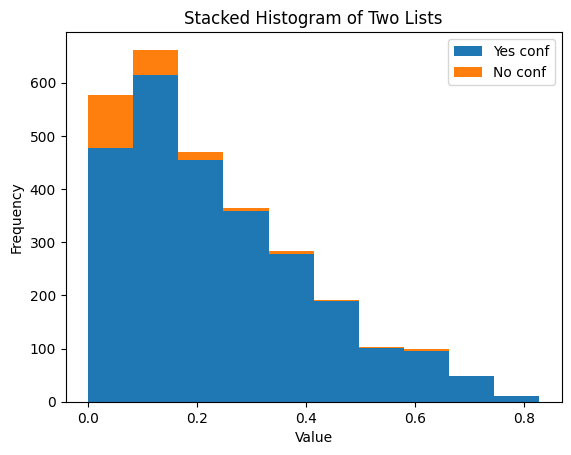

In [39]:
import matplotlib.pyplot as plt

# Creating histogram
plt.hist([yes_conf_np, no_conf_np], bins=10, stacked=True, label=['Yes conf', 'No conf'])

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Two Lists')
plt.legend()

# Show plot
plt.show()

## Test positive hallucinations for all images

In [ ]:
# All coco classes: cat_names
# Do it for all coco classes except those that should be there
import torch
from tqdm import tqdm
import pickle

coco_classes_set = set(cat_names)

MAX_SAMPLES = 1000
sample_ids = list(image_dict.keys())

yes_conf = []
no_conf = []
all_list = []
samples_used = []

for i in tqdm(range(MAX_SAMPLES)):
    # Get sample image and class set
    sample = image_dict[sample_ids[i]]
    sample["sample_id"] = sample_ids[i]
    image = sample["image"].convert("RGB")
    class_set = coco_classes_set.difference(sample["classes"])
    samples_used.append(sample)

    # For each object class
    for hall_class in class_set:
        prompt = f"<image>\nUSER: Is there a {hall_class} in the image? Only answer with 'yes' or 'no'.\nASSISTANT:"

        # Get owl vision embedding and owl output
        owl_vision_embedding = custom_owl.get_vision_features(image).detach()
        out_test = custom_owl.run_from_vision_features([hall_class], owl_vision_embedding)
        for key in out_test.keys():
            out_test[key] = out_test[key].detach()

        # Align embedding and run LLaVa
        image_features_fromowl = new_token_projection(owl_vision_embedding[:, 1:]).detach()
        gen_text = custom_llava.generate(prompt, image, custom_vision=image_features_fromowl)

        # Compute max owl confidence for class
        max_conf = torch.max(custom_owl.post_process_detection(out_test, threshold=0, target_sizes=[image.size])["scores"]).detach()

        # Get yes/no answer
        ans = gen_text.split("ASSISTANT: ")[1]

        all_list.append({"sample_id": sample_ids[i], "hall_class": hall_class, "ans": ans, "conf": max_conf})

        if ans == "Yes":
            yes_conf.append(max_conf)
        elif ans == "No":
            no_conf.append(max_conf)
        else:
            print("Answer not binary, skipping")

yes_conf_np = [float(conf.cpu().numpy()) for conf in yes_conf]
no_conf_np = [float(conf.cpu().numpy()) for conf in no_conf]

with open("/home/lorisg96/llm_draw/data/adversarial_results/hallucinations/true_hall.dat", "wb") as f:
    pickle.dump({"positive": yes_conf_np, "negative": no_conf_np, "all_list": all_list, "samples_used": samples_used}, f)

## Analyze results

In [2]:
# Read data
import pickle
with open("/home/lorisg96/llm_draw/data/adversarial_results/hallucinations/true_hall.dat", "rb") as f:
    reread_data = pickle.load(f)

In [ ]:
# Get mean of yes and no answers
import numpy as np
np.mean(reread_data["positive"]), np.mean(reread_data["negative"])

In [ ]:
# Visualize best

# Get samples that gave a "Yes" result
yes_samples = [(sample, i) for (sample, i) in zip(reread_data["all_list"], range(len(reread_data["all_list"]))) if sample["ans"]=="Yes"]

# Find the best ones (hallucinations with highest confidence)
highest_conf_samples = np.argsort(reread_data["positive"])[::-1]

MAX_DISPLAY = 25

for i in range(MAX_DISPLAY):
    sample_idx = highest_conf_samples[i]
    yes_sample = yes_samples[sample_idx][0]
    
    coco_sample = [sample for sample in reread_data["samples_used"] if yes_sample["sample_id"]==sample["sample_id"]][0]
    
    image = coco_sample["image"]
    hall_class = yes_sample["hall_class"]
    conf = float(yes_sample["conf"])

    # Run model and see hallucination
    prompt = f"<image>\nUSER: Is there a {hall_class} in the image? Only answer with 'yes' or 'no'.\nASSISTANT:"

    owl_vision_embedding = custom_owl.get_vision_features(image)
    out_test = custom_owl.run_from_vision_features([hall_class], owl_vision_embedding)

    image_features_fromowl = new_token_projection(owl_vision_embedding[:, 1:])  # TODO do i need [:, 1:]??
    gen_text = custom_llava.generate(prompt, image, custom_vision=image_features_fromowl)
    
    print(gen_text)
    det_image = custom_owl.draw_detections(image, [hall_class], out_test, conf-0.01)
    display(image)
    display(det_image)